In [40]:
import pandas as pd
import numpy as np
from collections import Counter
from vincenty import vincenty
from copy import deepcopy
from glob import glob
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt

In [61]:
colnames = ['lat','long', 'null', 'alt' ,'DateTime','Date','Time']
df = pd.read_csv('/Users/williamyee/Documents/Data Bootcamp/Project 4 GPS Cluster/Geolife Trajectories 1.3/Data/111/Trajectory/20090724005608.plt', skiprows=6, names = colnames)

In [44]:
def add_feat(df_input):
    df = df_input
    # add some initial shifts
    df['lat_shift'] = df.lat.shift(-1)
    df['long_shift'] = df.long.shift(-1)
    df['time_shift'] = df.DateTime.shift(-1)
    # add speed
    def speed(x):
        try:
            s = vincenty((x[-3],x[-2]),(x[0],x[1]), miles = True) / ((x[-1]-x[4]) * 24)
        except:
            s= np.nan
        return s
    df['speed_mph'] = df.apply(speed,axis =1)
    df['speed_shift'] = df.speed_mph.shift(-1)
    # add acceleration
    def accel(x):
        try:
            a = (x[-1] - x[-2]) / ((x[9] - x[4]) *24*60*60)
        except:
            a = np.nan
        return a
    df['acceleration'] = df.apply(accel, axis =1)
    df['acceleration_shift'] = df.acceleration.shift(-1)
    # add jerk
    def jerk(x):
        try:
            j = (x[-1] - x[-2]) / ((x[9] - x[4]) *24*60*60)
        except:
            j = np.nan
        return a
    df['jerk'] = df.apply(accel, axis =1)
    df['jerk_shift'] = df.jerk.shift(-1)

    def y(x):
        try:
            yy = np.sin((x[8] - x[0]) * np.pi/180) *np.cos( x[7]* np.pi/180)
        except:
            yy= np.nan
        return yy
    df['y'] = df.apply(y, axis =1)

    def x(x):
        try:
            xx = np.cos(x[0] * np.pi/180) *np.sin(x[7]* np.pi/180) - np.sin(x[0]* np.pi/180) * np.cos(x[7]* np.pi/180)*np.cos((x[8]-x[1])* np.pi/180)
        except:
            xx = np.nan
        return xx
    df['x'] = df.apply(x,axis =1)

    def bearing(x):
        try:
            b = np.arctan2(x[-2],x[-1])*180/np.pi
        except:
            b = np.nan
        return b
    df['bearing'] = df.apply(bearing,axis=1)

    df['brearing_shift'] = df.bearing.shift(-1)

    def bearing_rate(x):
        try:
            br = abs(x[-1]-x[-2])
        except:
            br = np.nan
        return br
    df['bearing_rate'] = df.apply(bearing_rate,axis=1)
    
    
    def distance(x):
        try:
            dist = vincenty((x[7],x[8]),(x[0],x[1]), miles = True)
        except:
            dist= np.nan
        return dist
    df['distance'] = df.apply(distance,axis = 1)
    
    
    df.drop(df.tail(4).index,inplace=True)
    return df

In [54]:
df = add_feat(df)

df.head()

for i,name in enumerate(add_feat(df).columns):
    print(i , name)

0 lat
1 long
2 null
3 alt
4 DateTime
5 Date
6 Time
7 lat_shift
8 long_shift
9 time_shift
10 speed_mph
11 speed_shift
12 acceleration
13 acceleration_shift
14 jerk
15 jerk_shift
16 y
17 x
18 bearing
19 brearing_shift
20 bearing_rate
21 distance


In [46]:
def list_df_summary(input_df):
    names = ['speed_10','speed_25','speed_50','speed_75','speed_90','speed_ave',
            'accel_10','accel_25','accel_50','accel_75','accel_90','accel_ave',
            'jerk_10','jerk_25','jerk_50','jerk_75','jerk_90','jerk_ave',
            'bearingRate_10','bearingRate_25','bearingRate_50','bearingRate_75','bearingRate_90','bearingRate_ave',
            'distance_traveled','time_traveled' ,'last_lat','last_long','start_lat','start_long'
            
            ]
    values = list()
    #speed
    values.append(input_df.quantile(.10)[8])
    values.append(input_df.quantile(.25)[8])
    values.append(input_df.quantile(.50)[8])
    values.append(input_df.quantile(.75)[8])
    values.append(input_df.quantile(.90)[8])
    values.append(input_df.mean()[8])
    #accel
    values.append(input_df.quantile(.10)[10])
    values.append(input_df.quantile(.25)[10])
    values.append(input_df.quantile(.50)[10])
    values.append(input_df.quantile(.75)[10])
    values.append(input_df.quantile(.90)[10])
    values.append(input_df.mean()[10])
    #jerk
    values.append(input_df.quantile(.10)[12])
    values.append(input_df.quantile(.25)[12])
    values.append(input_df.quantile(.50)[12])
    values.append(input_df.quantile(.75)[12])
    values.append(input_df.quantile(.90)[12])
    values.append(input_df.mean()[12])
    #bearing
    values.append(input_df.quantile(.10)[18])
    values.append(input_df.quantile(.25)[18])
    values.append(input_df.quantile(.50)[18])
    values.append(input_df.quantile(.75)[18])
    values.append(input_df.quantile(.90)[18])
    values.append(input_df.mean()[18])
    #distance travelled
    values.append(input_df.distance.sum())
    #time travelled
    values.append((input_df.iloc[-1,4] - input_df.iloc[0,4])*24*60)
    #lat long
    values.append(input_df.iloc[-1,0])
    values.append(input_df.iloc[-1,1])
    values.append(input_df.iloc[0,0])
    values.append(input_df.iloc[0,1])
    
    
    return pd.DataFrame([values],columns=names)

In [62]:
df2= add_feat(df)

In [63]:
df2

,lat,long,null,alt,DateTime,Date,Time,lat_shift,long_shift,time_shift,...,acceleration,acceleration_shift,jerk,jerk_shift,y,x,bearing,brearing_shift,bearing_rate,distance
0,36.405517,101.003750,0,10977.690289,40018.038981,2009-07-24,00:56:08,36.405700,101.004767,40018.039271,...,-0.031179,-5.332947e-04,0.001226,0.000778,0.727031,3.199845e-06,89.999748,90.000046,2.980184e-04,0.058059
1,36.405700,101.004767,0,10948.162730,40018.039271,2009-07-24,00:56:33,36.405667,101.005483,40018.039491,...,-0.000533,1.425226e-02,0.000778,-0.000210,0.727035,-5.817390e-07,90.000046,89.997914,2.132119e-03,0.040011
2,36.405667,101.005483,0,10862.860892,40018.039491,2009-07-24,00:56:52,36.407183,101.012050,40018.041586,...,0.014252,-2.376478e-02,-0.000210,0.000259,0.727060,2.647396e-05,89.997914,89.998120,2.064098e-04,0.380648
3,36.407183,101.012050,0,10892.388451,40018.041586,2009-07-24,00:59:53,36.408550,101.017617,40018.042917,...,-0.023765,6.000186e-03,0.000259,-0.000022,0.727072,2.385509e-05,89.998120,89.997478,6.418461e-04,0.324254
4,36.408550,101.017617,0,10915.354331,40018.042917,2009-07-24,01:01:48,36.410383,101.023833,40018.044988,...,0.006000,2.045104e-03,-0.000022,0.000807,0.727084,3.200051e-05,89.997478,89.999633,2.154940e-03,0.368820
5,36.410383,101.023833,0,10974.409449,40018.044988,2009-07-24,01:04:47,36.410650,101.024567,40018.045208,...,0.002045,1.738122e-02,0.000807,-0.001790,0.727075,4.654250e-06,89.999633,89.999771,1.375392e-04,0.044817
6,36.410650,101.024567,0,10977.690289,40018.045208,2009-07-24,01:05:06,36.410817,101.025033,40018.045347,...,0.017381,-4.096940e-03,-0.001790,0.000303,0.727074,2.908898e-06,89.999771,89.998510,1.260794e-03,0.028435
7,36.410817,101.025033,0,10980.971129,40018.045347,2009-07-24,01:05:18,36.411900,101.027917,40018.046192,...,-0.004097,1.803344e-02,0.000303,-0.001645,0.727081,1.890834e-05,89.998510,89.999840,1.329564e-03,0.177209
8,36.411900,101.027917,0,10990.813648,40018.046192,2009-07-24,01:06:31,36.412017,101.028267,40018.046296,...,0.018033,3.230254e-03,-0.001645,0.000074,0.727075,2.036226e-06,89.999840,89.995965,3.874214e-03,0.021100
9,36.412017,101.028267,0,10990.813648,40018.046296,2009-07-24,01:06:40,36.414950,101.036083,40018.048623,...,0.003230,1.807338e-02,0.000074,-0.001640,0.727094,5.120077e-05,89.995965,89.999542,3.576216e-03,0.480295


In [64]:
combined_data_speed = df2[['speed_mph','null']]
combined_data_acceleration = df2[['acceleration','null']]
combined_data_jerk = df2[['jerk','null']]
combined_data_bearing_rate = df2[['bearing_rate','null']]

In [65]:
combined_data_speed['value'] = 'Speed'
combined_data_acceleration['value'] = 'Acceleration'
combined_data_jerk['value'] = 'Jerk'
combined_data_bearing_rate['value'] = 'Bearing Rate'

combined_data_speed.rename(columns = {'speed_mph': 'numeric'}, inplace = True)
combined_data_acceleration.rename(columns = {'acceleration': 'numeric'}, inplace = True)
combined_data_jerk.rename(columns = {'jerk': 'numeric'}, inplace = True)
combined_data_bearing_rate.rename(columns = {'bearing_rate': 'numeric'}, inplace = True)

/Users/williamyee/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/williamyee/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/williamyee/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [70]:
combined_data_violin_plot = pd.concat([
    combined_data_acceleration,
    combined_data_bearing_rate,
    combined_data_jerk,
    combined_data_speed
])

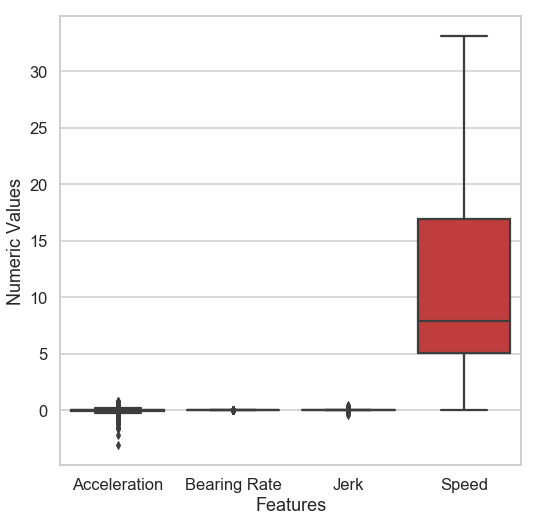

In [75]:
sns.set_style("whitegrid")
sns.set_context("talk")

a4_dims = (8.27, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
violin_plot = sns.boxplot(x = 'value', y ='numeric', data = combined_data_violin_plot);

violin_plot.set_xlabel('Features')
violin_plot.set_ylabel('Numeric Values')
plt.savefig('violinplot.png',bbox_inches="tight", dpi=400)

In [8]:
plts = []
for folder in glob('/Users/williamyee/Documents/Data Bootcamp/unsupervised-learning-metis/Geolife Trajectories 1.3/Data/*/Trajectory'):
    for file in glob(folder +'/*.plt'):
        plts.append(file)

In [9]:
large_df = []
for i, file in enumerate(plts):
    print( int(i*100 / len(plts)))
    try:
        large_df.append(list_df_summary(add_feat(pd.read_csv(file, skiprows=6,names=colnames))))
    except:
        pass
modeling_df = pd.concat(large_df)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


17
17
17
17
17
17
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
1

32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
3

47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
49
4

61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
6

76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
7

91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
92
9

In [ ]:
import pickle
pickle.dump(modeling_df, open('model_df5212019.p','wb'))

In [ ]:
modeling_df.shape

(18558, 30)

In [ ]:
modeling_df.head()

,speed_10,speed_25,speed_50,speed_75,speed_90,speed_ave,accel_10,accel_25,accel_50,accel_75,...,bearingRate_50,bearingRate_75,bearingRate_90,bearingRate_ave,distance_traveled,time_traveled,last_lat,last_long,start_lat,start_long
0,0.106560,0.555120,2.054162,3.578850,4.965843,2.622128,-0.447552,-0.156383,0.000000,0.175392,...,0.000011,0.000024,0.000046,0.000021,5.927997,258.700000,39.968487,116.399818,39.974294,116.399741
0,0.099360,0.722520,1.342082,2.559959,8.843378,4.790770,-0.577842,-0.163441,0.019871,0.249409,...,0.000016,0.000033,0.000050,0.000032,0.228077,4.616667,39.966182,116.395512,39.965813,116.396532
0,0.564336,2.056859,4.873190,21.399302,28.607910,11.862038,-2.016623,-0.389117,-0.001097,0.345506,...,0.000008,0.000018,0.000038,0.000026,5.087320,110.183333,26.424389,111.612672,26.391234,111.620290
0,0.124200,0.686310,2.161799,3.780002,4.911003,2.693128,-0.472651,-0.152696,-0.002448,0.168600,...,0.000013,0.000028,0.000047,0.000023,4.289100,202.683333,39.968135,116.399702,39.973755,116.398284
0,0.000000,0.202320,1.988641,11.342226,25.587666,7.444255,-1.278886,-0.180000,0.000000,0.226935,...,0.000008,0.000020,0.000042,0.000017,10.214986,285.333333,39.968139,116.399613,39.969352,116.398589
